<a href="https://colab.research.google.com/github/kashyapHebbar/CBCT_Reconstruction/blob/main/CBCT_Astra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing Astra-Toolbox and other Necessary Libraries

---



In [ ]:
!apt-get install -y libboost-all-dev
!apt-get install -y build-essential
!apt-get install -y libhdf5-serial-dev
!pip install pydicom
!pip install scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-all-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libhdf5-dev' instead of 'libhdf5-serial-dev'
libhdf5-dev is already the newest version (1.10.7+repack-4ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
!apt-get install -y autoconf libtool
! pip install cython

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
libtool is already the newest version (2.4.6-15build2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
!git clone https://github.com/astra-toolbox/astra-toolbox.git
!cd astra-toolbox/build/linux && ./autogen.sh && ./configure --with-cuda=/usr/local/cuda --with-python --with-install-type=module
!cd astra-toolbox/build/linux && make install -j 4
!pip install git+https://github.com/ahendriksen/tomosipo.git

fatal: destination path 'astra-toolbox' already exists and is not an empty directory.
configure.ac:42: warning: The macro `AC_PROG_LIBTOOL' is obsolete.
configure.ac:42: You should run autoupdate.
aclocal.m4:113: AC_PROG_LIBTOOL is expanded from...
configure.ac:42: the top level
Done.
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C... yes
checking whether gcc accepts -g... yes
checking for gcc option to enable C11 features... none needed
checking for a sed that does not truncate output... /usr/bin/sed
checking for grep that handles long lines and -e... /usr/bin/grep
checking for egrep... /usr/bin/grep -E

## Chaing the build path to linux


In [ ]:
import sys
sys.path.append('/content/astra-toolbox/build/linux/')

## Unzipping the dataset

In [ ]:
!unzip '/content/drive/MyDrive/PancreasCancer.zip'

# Code to Simulate the CBCT image




## Code to Display the CBCT image

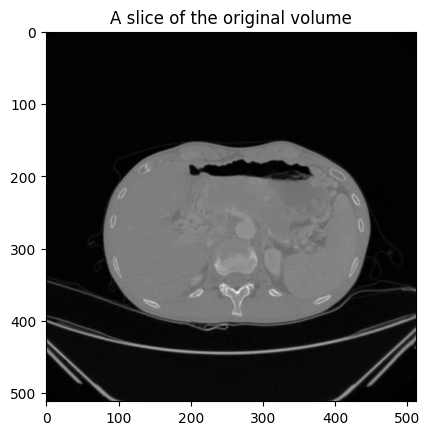

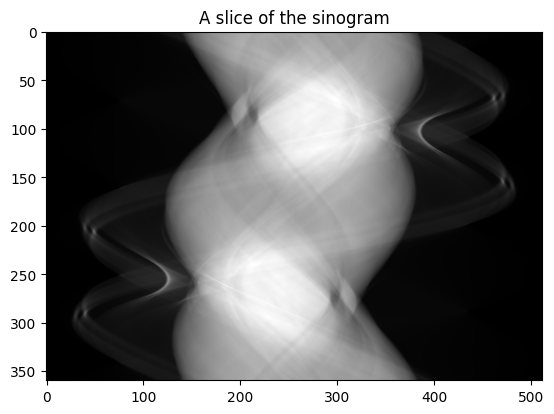

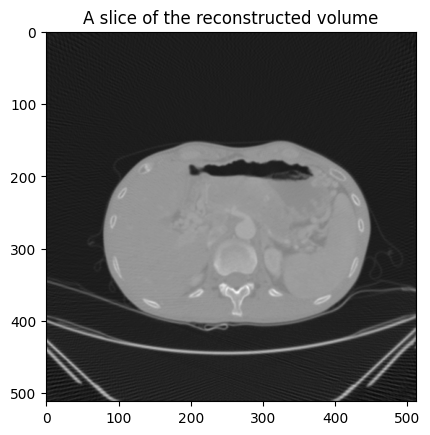

In [ ]:
import os
import pydicom
import numpy as np
import astra
import glob
import matplotlib.pyplot as plt

# Specify your DICOM images directory
PathDicom = "/content/PancreasCancer/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_28/03-25-2006-NA-ABDOMEN-40440/302.000000-Soft 3D A iDose 4-12011"
dicom_files = glob.glob(PathDicom + '/*.dcm')
dicom_files.sort()  # ensure they're in the correct order

# Get ref file
RefDs = pydicom.dcmread(dicom_files[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(dicom_files))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

# Create a 3D array to store the pixel data
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Loop through all the DICOM files
for filenameDCM in dicom_files:
    # read the file
    ds = pydicom.dcmread(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, dicom_files.index(filenameDCM)] = ds.pixel_array

# Transpose the volume data to match ASTRA's geometry dimensions (z, y, x)
volume_data = np.transpose(ArrayDicom, (2, 0, 1))

# Show the original slice
plt.figure()
plt.imshow(volume_data[volume_data.shape[0]//2, :, :], cmap='gray')
plt.title('A slice of the original volume')
plt.show()

# Create a volume geometry manually
vol_geom = astra.create_vol_geom(volume_data.shape[1], volume_data.shape[2], volume_data.shape[0])

# Create a data object for the volume
vol_id = astra.data3d.create('-vol', vol_geom, data=volume_data)

# Define projection geometry
proj_geom = astra.create_proj_geom('cone', 3.0, 3.0, 512, 512, np.linspace(0, 2*np.pi, 360, False), 800, 800)

# Perform a forward projection
proj_id, proj_data = astra.creators.create_sino3d_gpu(vol_id, proj_geom, vol_geom)

# Check the forward projection
plt.figure()
plt.imshow(proj_data[proj_data.shape[0]//2, :, :], cmap='gray')
plt.title('A slice of the sinogram')
plt.show()

# Set up the parameters for a reconstruction algorithm
cfg = astra.astra_dict('FDK_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = vol_id

# Optionally specify the number of iterations
cfg['option'] = {}
cfg['option']['MinConstraint'] = 0
cfg['option']['MaxIteration'] = 200  # choose an appropriate number of iterations

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run the algorithm
astra.algorithm.run(alg_id)

# Get the result
reconstruction = astra.data3d.get(vol_id)

# Visualize a slice of the reconstructed volume
plt.figure()
plt.imshow(reconstruction[reconstruction.shape[0]//2, :, :], cmap='gray')
plt.title('A slice of the reconstructed volume')
plt.show()

# Clean up
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)


## Code to Save the CBCT image


In [ ]:
import os
import pydicom
import numpy as np
import astra
import glob
from PIL import Image

# Specify your DICOM images directory
PathDicom = "/content/PancreasCancer/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_21/09-27-2001-NA-NA-15099/8.000000-Body 1.0 CE-17760"
dicom_files = glob.glob(PathDicom + '/*.dcm')
dicom_files.sort()  # ensure they're in the correct order

# Get ref file
RefDs = pydicom.dcmread(dicom_files[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(dicom_files))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

# Create a 3D array to store the pixel data
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Loop through all the DICOM files
for filenameDCM in dicom_files:
    # read the file
    ds = pydicom.dcmread(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, dicom_files.index(filenameDCM)] = ds.pixel_array

# Transpose the volume data to match ASTRA's geometry dimensions (z, y, x)
volume_data = np.transpose(ArrayDicom, (2, 0, 1))

# Create a volume geometry manually
vol_geom = astra.create_vol_geom(volume_data.shape[1], volume_data.shape[2], volume_data.shape[0])

# Create a data object for the volume
vol_id = astra.data3d.create('-vol', vol_geom, data=volume_data)

# Define projection geometry
proj_geom = astra.create_proj_geom('cone', 3.0, 3.0, 512, 512, np.linspace(0, 2*np.pi, 360, False), 800, 800)

# Perform a forward projection
proj_id, proj_data = astra.creators.create_sino3d_gpu(vol_id, proj_geom, vol_geom)

# Set up the parameters for a reconstruction algorithm
cfg = astra.astra_dict('FDK_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = vol_id

# Optionally specify the number of iterations
cfg['option'] = {}
cfg['option']['MinConstraint'] = 0
cfg['option']['MaxIteration'] = 200  # choose an appropriate number of iterations

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run the algorithm
astra.algorithm.run(alg_id)

# Get the result
reconstruction = astra.data3d.get(vol_id)

# Normalize the data to 0-255
reconstruction = ((reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))) * 255

# Output directory
output_dir = "/content/drive/MyDrive/CBCT/PAN_21/09-27-2001"
# Make sure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save each slice as an image
for i in range(reconstruction.shape[0]):
    # Get the slice
    slice_data = reconstruction[i, :, :]

    # Normalize the slice to 0-255
    slice_data = ((slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))) * 255

    # Convert to 8-bit pixel values
    slice_data = slice_data.astype(np.uint8)

    # Create the PIL Image object
    img = Image.fromarray(slice_data)

    # Save the image
    img.save(os.path.join(output_dir, f"slice_{i}.tif"))

# Clean up
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)


##Checking the Pairs of CT&CBCT


In [ ]:
import fnmatch
def get_image_files_in_dir(directory, image_format):
    image_files = []
    for dirpath, dirs, files in os.walk(directory):
        for filename in fnmatch.filter(files, f'*.{image_format}'):
            image_files.append(os.path.join(dirpath, filename))
    return image_files

def get_directory_list(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

CBCT_path = "/content/drive/MyDrive/CBCT/"
CT_path = "/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/"

# list out all the directories under the given path
cbct_dirs = get_directory_list(CBCT_path)
ct_dirs = get_directory_list(CT_path)

# find common directories
common_dirs = list(set(cbct_dirs) & set(ct_dirs))

# print the directories and the number of DICOM files
for dir_name in common_dirs:
    cbct_image_files = get_image_files_in_dir(os.path.join(CBCT_path, dir_name), 'tif')
    ct_dicom_files = get_image_files_in_dir(os.path.join(CT_path, dir_name), 'dcm')

    print(f"CT directory:\nNumber of DICOM files in {os.path.join(CT_path, dir_name)}: {len(ct_dicom_files)}")
    print(f"CBCT directory:\nNumber of TIF files in {os.path.join(CBCT_path, dir_name)}: {len(cbct_image_files)}\n")


CT directory:
Number of DICOM files in /content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_33: 460
CBCT directory:
Number of TIF files in /content/drive/MyDrive/CBCT/PAN_33: 460

CT directory:
Number of DICOM files in /content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_10: 764
CBCT directory:
Number of TIF files in /content/drive/MyDrive/CBCT/PAN_10: 764

CT directory:
Number of DICOM files in /content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_17: 526
CBCT directory:
Number of TIF files in /content/drive/MyDrive/CBCT/PAN_17: 526

CT directory:
Number of DICOM files in /content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_31: 473
CBCT directory:
Number of TIF files in /content/drive/MyDrive/CBCT/PAN_31: 473

CT directory:
Number of DICOM files in /content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_23: 639
CBCT directory:
Number of TIF files in /content/drive/MyDrive/CBCT/PAN_23: 

##Creating the Test & Training Dataset

In [ ]:
import pandas as pd

data = []

for dir_name in common_dirs:
    cbct_image_files = get_image_files_in_dir(os.path.join(CBCT_path, dir_name), 'tif')
    ct_dicom_files = get_image_files_in_dir(os.path.join(CT_path, dir_name), 'dcm')

    # check if the sequences have the same length
    assert len(cbct_image_files) == len(ct_dicom_files)

    # sort files to make sure they are in the same order
    cbct_image_files.sort()
    ct_dicom_files.sort()

    for cbct_file, ct_file in zip(cbct_image_files, ct_dicom_files):
        data.append({'CBCT': cbct_file, 'CT': ct_file})

df = pd.DataFrame(data)


In [ ]:
from sklearn.model_selection import train_test_split

# Create training and testing datasets (80-20 split)
train, test = train_test_split(df, test_size=0.2, random_state=42)

print(f"Total training pairs: {train.shape[0]}")
print(f"Total testing pairs: {test.shape[0]}")



Total training pairs: 17553
Total testing pairs: 4389


##Creating the ROI

In [ ]:
import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import imageio
from skimage import exposure
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split

# Function to load a DICOM image and extract a binary mask of the region of interest (ROI)
def contrast_stretching(image):
    # Stretch the contrast between the lower and upper percentiles of pixel intensities
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    return img_rescale

def load_image_and_extract_roi(file_path, threshold):
    if ".dcm" in file_path:
        image = pydicom.dcmread(file_path).pixel_array
    elif ".tif" in file_path:
        image = imageio.imread(file_path)

    _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    return image, binary_mask

# Function to display the image and the ROI side by side
def display_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 15))

    for i, ax in enumerate(axs):
        ax.imshow(images[i], cmap='gray')
        ax.title.set_text(titles[i])

    plt.show()

# Paths to the directories with CT and CBCT images
ct_dir = '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET'
cbct_dir = '/content/drive/MyDrive/CBCT'

ct_images = []
cbct_images = []

# Walk through the CT and CBCT directories simultaneously
for (ct_dirpath, ct_dirnames, ct_filenames), (cbct_dirpath, cbct_dirnames, cbct_filenames) in zip(os.walk(ct_dir), os.walk(cbct_dir)):
    for ct_filename, cbct_filename in zip(ct_filenames, cbct_filenames):
        # Check if the files are DICOM and TIFF files respectively
        if '.dcm' in ct_filename and '.tif' in cbct_filename:
            ct_file_path = os.path.join(ct_dirpath, ct_filename)
            cbct_file_path = os.path.join(cbct_dirpath, cbct_filename)

            # Load the CT image and extract the ROI
            ct_image, ct_roi = load_image_and_extract_roi(ct_file_path, threshold=250)  # Threshold value for CT images

            # Load the CBCT image and extract the ROI
            cbct_image, cbct_roi = load_image_and_extract_roi(cbct_file_path, threshold=40)  # Threshold value for CBCT images

            # Display the original images and the binary masks for CT and CBCT
            display_images([ct_image, ct_roi, cbct_image, cbct_roi], ['CT Image', 'CT ROI', 'CBCT Image', 'CBCT ROI'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data-Preprocessing

In [ ]:
!pip install SimpleITK


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 26.1 MB/s eta 0:00:00


In [ ]:
import os

def retrieve_files(dir_path, extensions):
    files = []
    for dirpath, dirnames, filenames in os.walk(dir_path):
        for filename in filenames:
            if filename.endswith(extensions):
                files.append(os.path.join(dir_path, dirpath, filename))
    return files

# Specify the paths to your directories
dicom_dir = '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET'
tif_dir = '/content/drive/MyDrive/CBCT'

# Retrieve DICOM and TIFF files
dicom_files = retrieve_files(dicom_dir, ('.dcm', '.dicom'))
tif_files = retrieve_files(tif_dir, '.tif')

# Print number of images and some examples
print(f'Total number of DICOM files: {len(dicom_files)}')
print(f'Some DICOM paths: {dicom_files[:5]}')

print(f'Total number of TIFF files: {len(tif_files)}')
print(f'Some TIFF paths: {tif_files[:5]}')


Total number of DICOM files: 21942
Some DICOM paths: ['/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_03/01-10-2004/Slice_0.dcm', '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_03/01-10-2004/Slice_1.dcm', '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_03/01-10-2004/Slice_2.dcm', '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_03/01-10-2004/Slice_3.dcm', '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET/PAN_03/01-10-2004/Slice_4.dcm']
Total number of TIFF files: 21942
Some TIFF paths: ['/content/drive/MyDrive/CBCT/PAN_02/06-08-2000/Slice_0.tif', '/content/drive/MyDrive/CBCT/PAN_02/06-08-2000/Slice_1.tif', '/content/drive/MyDrive/CBCT/PAN_02/06-08-2000/Slice_2.tif', '/content/drive/MyDrive/CBCT/PAN_02/06-08-2000/Slice_3.tif', '/content/drive/MyDrive/CBCT/PAN_02/06-08-2000/Slice_4.tif']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test sets (10%)
train_files, temp_files = train_test_split(dicom_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Let's check the size of each set
print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

# Now let's create a PyTorch dataset
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import pydicom

# Function to load a DICOM image
def load_dicom_image(file):
    ds = pydicom.dcmread(file)
    img = ds.pixel_array
    return img

# Our custom dataset
class MyDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = load_dicom_image(file_path)
        image = Image.fromarray(image)  # Convert to PIL image
        if self.transform:
            image = self.transform(image)
        return image

# Transformation (you might want to normalize your data or apply other transformations)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create datasets
train_dataset = MyDataset(train_files, transform=transform)
val_dataset = MyDataset(val_files, transform=transform)
test_dataset = MyDataset(test_files, transform=transform)


Number of training files: 17553
Number of validation files: 2194
Number of test files: 2195


In [ ]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pydicom
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Your function for generating the mask
# Please replace this with your real function
def get_mask(image):
    # Create the mask here and return it
    pass

def get_dataset_paths():
    dicom_dir = '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET'  # path to your dicom images
    tiff_dir = '/content/drive/MyDrive/CBCT'  # path to your tiff images

    dicom_paths = []
    tiff_paths = []

    for dirpath, _, filenames in os.walk(dicom_dir):
        for f in filenames:
            if f.lower().endswith('.dcm'):  # Only include DICOM files
                dicom_paths.append(os.path.abspath(os.path.join(dirpath, f)))

    for dirpath, _, filenames in os.walk(tiff_dir):
        for f in filenames:
            if f.lower().endswith('.tif') or f.lower().endswith('.tiff'):  # Only include TIFF files
                tiff_paths.append(os.path.abspath(os.path.join(dirpath, f)))

    dicom_paths.sort()
    tiff_paths.sort()

    return dicom_paths, tiff_paths

class CustomDataset(Dataset):
    def __init__(self, dicom_paths, tiff_paths, transform=None):
        self.dicom_paths = dicom_paths
        self.tiff_paths = tiff_paths
        self.transform = transform

    def __len__(self):
        return len(self.dicom_paths)

    def __getitem__(self, idx):
        dicom_path = self.dicom_paths[idx]
        tiff_path = self.tiff_paths[idx]

        ds = pydicom.dcmread(dicom_path)
        dicom_image = ds.pixel_array
        dicom_mask = get_mask(dicom_image)
        np.save(dicom_path.replace('.dcm', '.npy'), dicom_mask)  # Save mask as .npy file
        dicom_image = Image.fromarray(dicom_image)

        tiff_image = Image.open(tiff_path)
        tiff_image = tiff_image.convert("L")
        tiff_mask = get_mask(np.array(tiff_image))
        np.save(tiff_path.replace('.tif', '.npy'), tiff_mask)  # Save mask as .npy file

        sample = {"dicom": dicom_image, "tiff": tiff_image}

        if self.transform:
            sample["dicom"] = self.transform(sample["dicom"])
            sample["tiff"] = self.transform(sample["tiff"])

        combined = torch.stack([sample["dicom"][0], sample["tiff"][0]])

        return combined, combined

print("Getting dataset paths...")
dicom_paths, tiff_paths = get_dataset_paths()

print("Splitting data into train, validation, and test sets...")
dicom_train, dicom_test, tiff_train, tiff_test = train_test_split(dicom_paths, tiff_paths, test_size=0.1, random_state=42)
dicom_train, dicom_val, tiff_train, tiff_val = train_test_split(dicom_train, tiff_train, test_size=0.1, random_state=42)

print("Creating PyTorch Datasets...")
transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
train_data = CustomDataset(dicom_train, tiff_train, transform=transform)
val_data = CustomDataset(dicom_val, tiff_val, transform=transform)
test_data = CustomDataset(dicom_test, tiff_test, transform=transform)

# Save datasets to .pth files for quicker loading
print("Saving datasets to .pth files...")
torch.save(train_data, '/content/drive/MyDrive/train_data.pth')
torch.save(val_data, '/content/drive/MyDrive/val_data.pth')
torch.save(test_data, '/content/drive/MyDrive/test_data.pth')


Getting dataset paths...
Splitting data into train, validation, and test sets...
Creating PyTorch Datasets...
Saving datasets to .pth files...


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00


In [ ]:
from monai.networks.nets.swin_unetr import SwinTransformer as SwinViT
from monai.utils import ensure_tuple_rep
import torch
import torch.nn as nn

class SSLHead(nn.Module):
    def __init__(self, upsample="vae", dim=768):
        super(SSLHead, self).__init__()
        patch_size = ensure_tuple_rep(2, 3)
        window_size = ensure_tuple_rep(7, 3)
        self.swinViT = SwinViT(
            in_chans=1,
            embed_dim=48,
            window_size=window_size,
            patch_size=patch_size,
            depths=[2, 2, 2, 2],
            num_heads=[3, 6, 12, 24],
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            drop_path_rate=0.1,
            norm_layer=torch.nn.LayerNorm,
            use_checkpoint=True,
            spatial_dims=3,
        )


    def forward(self, x):
      x = self.swinVit(x.contiguous())
      return x

In [ ]:
model = SwinViT(
            in_chans=1,
            embed_dim=48,
            window_size=ensure_tuple_rep(7, 3),
            patch_size=ensure_tuple_rep(2, 3),
            depths=[2, 2, 2, 2],
            num_heads=[3, 6, 12, 24],
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            drop_path_rate=0.1,
            norm_layer=torch.nn.LayerNorm,
            use_checkpoint=True,
            spatial_dims=3,
        )

In [ ]:
model = SSLHead()

In [ ]:
print(model.parameters)

In [ ]:
im = torch.randn(1,1,96,96,96)

In [ ]:
res = model(im)

In [ ]:
len(res)

5

In [ ]:
!pip install -U monai

!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.6 MB/s eta 0:00:00


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from monai.data import ArrayDataset
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor
from monai.networks.nets import UNet

# Function to apply masks
def apply_mask(image, mask, fill=-1000):
    masked = image.copy()
    masked[~mask] = fill
    return masked

# Function for registration
def register_images(fixed_image, moving_image):
    # Create ImageRegistrationMethod object
    R = sitk.ImageRegistrationMethod()

    # Set the Similarity metric
    R.SetMetricAsMeanSquares()

    # Interpolator
    R.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings
    R.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
    R.SetOptimizerScalesFromPhysicalShift()

    # Set the initial transformation (identity)
    initial_transform = sitk.TranslationTransform(fixed_image.GetDimension())
    R.SetInitialTransform(initial_transform)

    # Execute the registration
    final_transform = R.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                sitk.Cast(moving_image, sitk.sitkFloat32))

    # Resample the moving image with the final transformation
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    return moving_resampled

# Load your images
ct_image_dir = '/content/drive/MyDrive/manifest-1662644254281/CTpred-Sunitinib-panNET'
cbct_image_dir = '/content/drive/MyDrive/CBCT'

ct_image_paths = [os.path.join(dirpath, filename) for dirpath, dirnames, filenames in os.walk(ct_image_dir) for filename in filenames if filename.endswith('.dcm')]
ct_image_paths.sort()  # Important to sort the filenames as os.walk does not guarantee ordered output
ct_image_sitk = sitk.ReadImage(ct_image_paths)

cbct_image_paths = [os.path.join(dirpath, filename) for dirpath, dirnames, filenames in os.walk(cbct_image_dir) for filename in filenames if filename.endswith('.tif')]
cbct_image_paths.sort()  # Important to sort the filenames as os.walk does not guarantee ordered output
cbct_image_sitk = sitk.ReadImage(cbct_image_paths)

# Apply masks
ct_image_np = sitk.GetArrayFromImage(ct_image_sitk)
cbct_image_np = sitk.GetArrayFromImage(cbct_image_sitk)

mask_ct = ct_image_np > threshold_otsu(ct_image_np)
mask_cbct = cbct_image_np > threshold_otsu(cbct_image_np)

ct_image_masked = apply_mask(ct_image_np, mask_ct, fill=-1000)
cbct_image_masked = apply_mask(cbct_image_np, mask_cbct, fill=-1000)

ct_image_masked_sitk = sitk.GetImageFromArray(ct_image_masked)
cbct_image_masked_sitk = sitk.GetImageFromArray(cbct_image_masked)

# Register images
ct_image_registered_sitk = register_images(ct_image_masked_sitk, cbct_image_masked_sitk)

# Convert registered images to numpy arrays
ct_image_registered = sitk.GetArrayFromImage(ct_image_registered_sitk)

# Rest of your code for splitting, transforming, training and visualizing...


# Split into training and validation sets
split_idx = int(0.8 * len(ct_images_registered))  # 80% for training, 20% for validation
cbct_images_train, pctr_images_train = cbct_images_np[:split_idx], ct_images_registered[:split_idx]
cbct_images_val, pctr_images_val = cbct_images_np[split_idx:], ct_images_registered[split_idx:]

# Define transformations for the image and mask
transforms = Compose([
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

# Create datasets
train_ds = ArrayDataset(cbct_images_train, transforms, pctr_images_train, transforms)
val_ds = ArrayDataset(cbct_images_val, transforms, pctr_images_val, transforms)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

# Define model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(dimensions=2, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2)).to(device)
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}")

    model.eval()
    with torch.no_grad():
        num_correct = 0
        total = 0
        for val_data in val_loader:
            inputs, labels = val_data[0].to(device), val_data[1].to(device)
            outputs = model(inputs)
            predict_classes = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            num_correct += (predict_classes == labels).sum().item()

        print(f"Epoch {epoch+1}/{num_epochs}, Validation accuracy: {num_correct/total*100:.2f}%")

# Visualize a slice before and after registration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ct_images_np[0], cmap="gray")
plt.title("Before registration")
plt.subplot(1, 2, 2)
plt.imshow(ct_images_registered[0], cmap="gray")
plt.title("After registration")
plt.show()


In [ ]:
import os
import shutil

# Your directories
ct_dir = '/content/drive/MyDrive/20CT'
cbct_dir = '/content/drive/MyDrive/20CBCT'

# Destination directories
local_ct_dir = '/content/local_CT'
local_cbct_dir = '/content/local_CBCT'

os.makedirs(local_ct_dir, exist_ok=True)
os.makedirs(local_cbct_dir, exist_ok=True)

# Copy CT files
for filename in os.listdir(ct_dir):
    if filename.endswith('.dcm'):  # To ensure only .dcm files are copied
        shutil.copy(os.path.join(ct_dir, filename), local_ct_dir)

# Copy CBCT files
for filename in os.listdir(cbct_dir):
    if filename.endswith('.tif'):  # To ensure only .tif files are copied
        shutil.copy(os.path.join(cbct_dir, filename), local_cbct_dir)


In [ ]:
import os
import shutil

# Your directories
ct_dir = '/content/drive/MyDrive/20CT'
cbct_dir = '/content/drive/MyDrive/20CBCT'

# Destination directories
local_ct_dir = '/content/local_CT'
local_cbct_dir = '/content/local_CBCT'

# Make sure the destination directories do not exist
if os.path.exists(local_ct_dir):
    shutil.rmtree(local_ct_dir)
if os.path.exists(local_cbct_dir):
    shutil.rmtree(local_cbct_dir)

# Copy directories
shutil.copytree(ct_dir, local_ct_dir)
shutil.copytree(cbct_dir, local_cbct_dir)


'/content/local_CBCT'